In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import rdkit
from rdkit import DataStructs
import rdkit.Chem.AllChem as Chem

import olympus
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.campaigns import Campaign 
from olympus.scalarizers import Scalarizer
from olympus.plotter import Plotter

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set



In [35]:
# helper functions


def get_single_traces(campaigns):
    traces = []
    for campaign in campaigns:
        trace = campaign.best_values
        assert trace.shape[1]==1
        traces.append(trace)
    return np.array(traces).squeeze(axis=-1)
    

def get_traces(campaigns, scalarizer, return_n_best_params=10):
    traces = []
    best_n_params = []
    for campaign in campaigns:
#         print(campaign.observations.get_values().shape)
        values = campaign.observations.get_values()
        params = campaign.observations.get_params()
        scalarized = scalarizer.scalarize(values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        #instance_trace = []
        trace0 = values[trace_best_idx, 0]
        trace1 = values[trace_best_idx, 1]
        trace2 = values[trace_best_idx, 2]
        traces.append([trace0, trace1, trace2])
        
        sort_idx = np.argsort(scalarized)
        best_n_params.append(list(params[sort_idx][:return_n_best_params]))
        
        
    return np.array(traces), best_n_params


def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)
    


def plot_trace_mean(traces, obj_num=0, ax=None, color=None, label=None, use_std_err=True):

    if obj_num==None:
        pass
    elif isinstance(obj_num, int):
        traces = traces[:, obj_num, :]
        
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

## `redoxmers` example

In [36]:
dataset = 'redoxmers'
case_study = 'case_study_3'

# load results

data_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/RandomSearch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gpyopt/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
    
        
data_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Botorch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
        
data_gryffin = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gryffin/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gryffin_ = pickle.load(content)
        data_gryffin[sub] = data_gryffin_
        
        
# data_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego']:
#     with open(f'{case_study}/Hebo/{sub}/results.pkl', 'rb') as content:
#         data_hebo_ = pickle.load(content)
#         data_hebo[sub] = data_hebo_

data_gryffin['Chimera']

[<Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>]

In [37]:
scalarizers = {'Chimera' : Scalarizer(
                            kind='Chimera', 
                            value_space=Dataset(kind='redoxmers').value_space,
                            goals=['min', 'min', 'min'],
                            tolerances=[25., 2.04, 0.0],
                            absolutes=[True, True, False]
                        ),
               'WeightedSum':
                    Scalarizer(
                        kind='WeightedSum', 
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                        weights=[3., 2., 1.],
                    ),
                'Parego':
                   Scalarizer(
                        kind='Parego', 
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                        rho=0.05,
                    ),
                'Hypervolume':
                    Scalarizer(
                        kind='Hypervolume',
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                    )
              }


# get traces
traces_random = {}
best_n_params = {}
best_n_params_df = []
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_random[sub], best_n_params[sub] = get_traces(data_random[sub], scalarizers[sub])
    
traces_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gpyopt[sub], best_n_params[sub] = get_traces(data_gpyopt[sub], scalarizers[sub])

traces_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_botorch[sub], best_n_params[sub] = get_traces(data_botorch[sub], scalarizers[sub])
    
traces_gryffin = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gryffin[sub], best_n_params[sub] = get_traces(data_gryffin[sub], scalarizers[sub])
    
# traces_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
#     traces_hebo[sub]= get_traces(data_hebo[sub], scalarizers[sub])

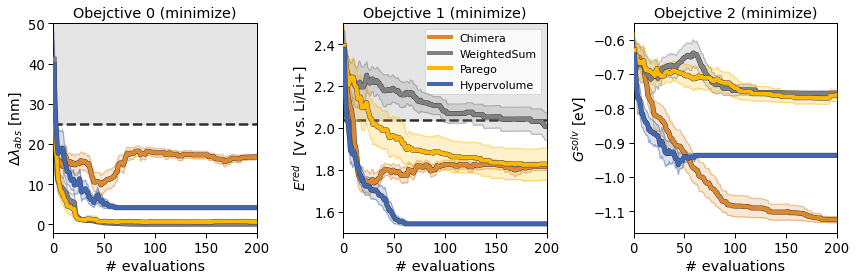

In [9]:
#---------------
# BOTORCH
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_botorch['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_botorch['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_botorch['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_botorch['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')

axes[0].set_title(f'Obejctive 0 (minimize)')
axes[1].set_title(f'Obejctive 1 (minimize)')
axes[2].set_title(f'Obejctive 2 (minimize)')    

#axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right', ncol=1, fontsize=11)

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel(r'$\Delta \lambda_{abs}$ [nm]', fontsize=14)
axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=14)
axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=14)

axes[0].axhline(25., ls='--',  c='k', lw=2.5, alpha=0.8)
axes[0].fill_between(x=[0,200], y1=25., y2=50, alpha=0.2, color='gray')
axes[0].set_xlim(0, 200)
axes[0].set_ylim(-2, 50)


axes[1].axhline(2.04, ls='--',  c='k', lw=2.5, alpha=0.8)
axes[1].fill_between(x=[0,200], y1=2.04, y2=2.5, alpha=0.2, color='gray')
axes[1].set_xlim(0, 200)
axes[1].set_ylim(1.5, 2.5)


#axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
plt.savefig('redoxmers_botorch_traces.png', dpi=300)

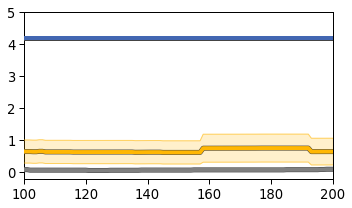

In [18]:
# zoomed in plot of first objective

fig, ax = plt.subplots(figsize=(5, 3))

plot_trace_mean(traces_botorch['Chimera'], obj_num=0, ax=ax, color='#dd882c', label='Chimera')
plot_trace_mean(traces_botorch['WeightedSum'], obj_num=0, ax=ax, color='gray', label='WeightedSum')
plot_trace_mean(traces_botorch['Parego'], obj_num=0, ax=ax, color='#ffb703', label='Parego')
plot_trace_mean(traces_botorch['Hypervolume'], obj_num=0, ax=ax, color='#4267B2', label='Hypervolume')

ax.set_xlim(100, 200)
ax.set_ylim(-0.2, 5)
plt.tight_layout()
plt.savefig('redoxmers_botorch_obj1_zoom_in.png', dpi=300)

In [19]:
df_orig = Dataset(kind='redoxmers').data

In [20]:
df_orig.head()

,r1_label,r3_label,r4_label,r5_label,abs_lam_diff,ered,gsol
0,R1_0,R3_0,R4_0,R5_0,39.96,1.684123,-0.681801
1,R1_0,R3_0,R4_0,R5_1,63.92,1.963624,-0.711542
2,R1_0,R3_0,R4_0,R5_2,51.76,2.044655,-0.8874
3,R1_0,R3_0,R4_0,R5_3,36.93,1.731604,-0.710235
4,R1_0,R3_0,R4_0,R5_4,53.79,1.844226,-0.748112


In [21]:
raw_df = pd.read_csv('../src/olympus/datasets/dataset_redoxmers/raw_data/df_results.csv')
# make product mols
prod_smiles = raw_df['product_smiles'].tolist()
prod_mols = [Chem.MolFromSmiles(s) for s in prod_smiles]

# prod_fps = [np.array(Chem.GetMorganFingerprintAsBitVect(m, 3)) for m in prod_mols ]
prod_fps = [Chem.GetMorganFingerprintAsBitVect(m, 3) for m in prod_mols ]
fps_dict = {s:fp for s, fp in zip(prod_smiles, prod_fps)}
raw_df['product_mols'] = prod_mols
print(raw_df.shape)
raw_df.head()

(1407, 2395)


,Unnamed: 0,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,...,r5_MW,r5_AMW,r5_WPath,r5_WPol,r5_Zagreb1,r5_Zagreb2,r5_mZagreb2,r5_type,r5_ix,product_mols
0,0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,16.031300,3.206260,0,0,0.0,0.0,0.0,R5,0,<rdkit.Chem.rdchem.Mol object at 0x7f674bac9df0>
1,1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,70.003035,14.000607,9,0,12.0,9.0,1.0,R5,1,<rdkit.Chem.rdchem.Mol object at 0x7f674bbfa080>
2,2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,27.010899,9.003633,1,0,2.0,1.0,1.0,R5,2,<rdkit.Chem.rdchem.Mol object at 0x7f674bb8b080>
3,3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,32.026215,5.337702,1,0,2.0,1.0,1.0,R5,3,<rdkit.Chem.rdchem.Mol object at 0x7f674bacb120>
4,4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,85.997949,14.332992,16,0,20.0,16.0,1.0,R5,4,<rdkit.Chem.rdchem.Mol object at 0x7f674bcb85d0>


In [23]:
def lookup_prod_smiles_mol(r1_label, r3_label, r4_label, r5_label, raw_df):
    
    match = raw_df[
        (raw_df['r1_label']==r1_label)&
        (raw_df['r3_label']==r3_label)&
        (raw_df['r4_label']==r4_label)&
        (raw_df['r5_label']==r5_label)
    ]
    assert len(match)==1
    match = match.to_dict('r')[0]
    smi, mol = match['product_smiles'], match['product_mols']
    fp = fps_dict[smi]
    return smi, mol, fp

def get_similarity_distribution(campaigns, raw_df):
    
    smiles, mols, fps = [], [], []

    for campaign in campaigns:
        for param in campaign.observations.get_params():
            # this is dataset specific
            smi, mol, fp = lookup_prod_smiles_mol(param[0], param[1], param[2], param[3], raw_df)
            smiles.append(smi)
            mols.append(mol)
            fps.append(fp)
    # compute all fp pairwise distances without duplicates
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps)-1): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(smiles[n])
            ta.append(smiles[n+1:][m])
            sim.append(s[m])

    d = {'query':qu, 'target':ta, 'similarity':sim}
    df_sim = pd.DataFrame(data=d)
    #df_sim = df_sim.sort_values('similarity', ascending=False)
    
    return df_sim




In [24]:
# df_sim_chimera = get_similarity_distribution(data_gpyopt['Chimera'][:1], raw_df)
# df_sim_weightedsum = get_similarity_distribution(data_gpyopt['WeightedSum'][:1], raw_df)
# df_sim_parego = get_similarity_distribution(data_gpyopt['Parego'][:1], raw_df)
# df_sim_hypervolume = get_similarity_distribution(data_gpyopt['Hypervolume'][:1], raw_df)

In [39]:

best_n_params

{'Chimera': [[array(['R1_0', 'R3_7', 'R4_3', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_0', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_2'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_0'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_5'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_3', 'R5_1'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_6'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_3', 'R5_3'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_0', 'R5_3'], dtype='<U5')],
  [array(['R1_0', 'R3_7', 'R4_3', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_0', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_0'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_2', 'R5_3'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_5'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_6'], dtype='<U5'),
   array(['R1

In [56]:
def get_pareto_data(campaigns):
    
    pareto_fronts, pareto_sets = [], []
    hypervolumes = []
    values_ = []

    # get the pareto optimal sets and the hypervolumes after the 200 evaluation budget
    for campaign in campaigns:

        params = campaign.observations.get_params()
        values = campaign.observations.get_values()

        pareto_front, pareto_set = get_pareto_set(params, values)
        w_ref = np.amax(df_orig[['abs_lam_diff', 'ered', 'gsol']].values, axis=0)
        #print(w_ref)
        hypervolume = get_hypervolume(values, w_ref)
        

        pareto_fronts.append(pareto_front)
        pareto_sets.append(pareto_set)
        hypervolumes.append(hypervolume)


        idxs = [ np.where(np.all(values==p, axis=1))[0][0] for p in pareto_front ] 
        assert len(idxs)==pareto_front.shape[0]
        values = np.delete(values, idxs, axis=0)
        values_.append(values)
        
    return pareto_fronts, pareto_sets, hypervolumes, values_
    

def make_plotly_df(pareto_fronts, values_):
    front_df = pd.DataFrame(
        {'abs_lam_diff': pareto_fronts[:, 0], 'ered': pareto_fronts[:, 1], 'gsol': pareto_fronts[:, 2]}
    )
    front_df['type'] = 'front'
    front_df['size'] = 10
    full_df = pd.DataFrame(
        {'abs_lam_diff': values_[:, 0], 'ered': values_[:, 1], 'gsol': values_[:, 2]}
    )
    full_df['type'] = 'normal'
    full_df['size'] = 2
    df = pd.concat((front_df, full_df))
    return df


In [80]:
pareto_fronts_hv, pareto_sets_hv, hypervolumes_hv, values_hv = get_pareto_data(data_gpyopt['Hypervolume'])
df_hv = make_plotly_df(pareto_fronts_hv[0], values_hv[0])

pareto_fronts_chi, pareto_sets_chi, hypervolumes_chi, values_chi = get_pareto_data(data_gpyopt['Chimera'])
df_chi = make_plotly_df(pareto_fronts_chi[0], values_chi[0])


pareto_fronts_ws, pareto_sets_ws, hypervolumes_ws, values_ws = get_pareto_data(data_gpyopt['WeightedSum'])
df_ws = make_plotly_df(pareto_fronts_ws[0], values_ws[0])

pareto_fronts_par, pareto_sets_par, hypervolumes_par, values_par = get_pareto_data(data_gpyopt['Parego'])
df_par = make_plotly_df(pareto_fronts_par[0], values_par[0])

# make pareto sets df
all_pareto_sets = {'method': [], 'R1': [], 'R3': [], 'R4': [], 'R5': [], 'smiles': []}
for method, data in zip(['Hypervolume', 'Chimera', 'ParEGO', 'Weighted Sum'], [pareto_sets_hv,pareto_sets_chi,pareto_sets_ws,pareto_sets_par]):
    
    for array in data:
        for instance in array:
            all_pareto_sets['method'].append(method)
            all_pareto_sets['R1'].append(instance[0])
            all_pareto_sets['R3'].append(instance[1])
            all_pareto_sets['R4'].append(instance[2])
            all_pareto_sets['R5'].append(instance[3])
            smiles = lookup_prod_smiles_mol(
                instance[0], instance[1], instance[2], instance[3], raw_df
            )
            all_pareto_sets['smiles'].append(smiles)
            
            
pareto_sets_df = pd.DataFrame(all_pareto_sets)
    



# full hypervolume
values = df_orig[['abs_lam_diff', 'ered', 'gsol']].values
w_ref = np.amax(values, axis=0)
#print(w_ref)
full_hypervolume = get_hypervolume(values, w_ref)


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



In [84]:
pareto_sets_df.head()

,method,R1,R3,R4,R5,smiles
0,Hypervolume,R1_0,R3_7,R4_3,R5_3,"(CCOCN(C(C)=O)c1c(N(C)C)c(OC)c(OC)c2nsnc12, <r..."
1,Hypervolume,R1_0,R3_7,R4_0,R5_10,(CCOCN(C(C)=O)c1c(N(C)C)c(C)c(S(=O)(=O)N(C)C)c...
2,Hypervolume,R1_0,R3_7,R4_7,R5_10,(CCOCN(C(C)=O)c1c(N(C)C)c(N(C)C)c(S(=O)(=O)N(C...
3,Hypervolume,R1_0,R3_7,R4_3,R5_10,(CCOCN(C(C)=O)c1c(N(C)C)c(OC)c(S(=O)(=O)N(C)C)...
4,Hypervolume,R1_0,R3_5,R4_7,R5_10,(CCOCN(C(C)=O)c1c(SC)c(N(C)C)c(S(=O)(=O)N(C)C)...


In [92]:

hv_sets = pareto_sets_df[pareto_sets_df['method']=='Hypervolume']
hv_counts_r1 = hv_sets['R1'].value_counts()
hv_counts_r3 = hv_sets['R3'].value_counts()
hv_counts_r4 = hv_sets['R4'].value_counts()
hv_counts_r5 = hv_sets['R5'].value_counts()
hv_counts_smiles = hv_sets['smiles'].value_counts()

chi_sets = pareto_sets_df[pareto_sets_df['method']=='Chimera']
chi_counts_r1 = chi_sets['R1'].value_counts()
chi_counts_r3 = chi_sets['R3'].value_counts()
chi_counts_r4 = chi_sets['R4'].value_counts()
chi_counts_r5 = chi_sets['R5'].value_counts()
chi_counts_smiles = chi_sets['smiles'].value_counts()

par_sets = pareto_sets_df[pareto_sets_df['method']=='ParEGO']
par_counts_r1 = par_sets['R1'].value_counts()
par_counts_r3 = par_sets['R3'].value_counts()
par_counts_r4 = par_sets['R4'].value_counts()
par_counts_r5 = par_sets['R5'].value_counts()
par_counts_smiles = par_sets['smiles'].value_counts()

ws_sets = pareto_sets_df[pareto_sets_df['method']=='Weighted Sum']
ws_counts_r1 = ws_sets['R1'].value_counts()
ws_counts_r3 = ws_sets['R3'].value_counts()
ws_counts_r4 = ws_sets['R4'].value_counts()
ws_counts_r5 = ws_sets['R5'].value_counts()
ws_counts_smiles = ws_sets['smiles'].value_counts()

In [63]:
df_hvol = pd.concat([
    pd.DataFrame({'hypervol': hypervolumes_hv, 'kind': ['Hypervolume' for _ in range(len(hypervolumes_hv))]}),
    pd.DataFrame({'hypervol': hypervolumes_chi, 'kind': ['Chimera' for _ in range(len(hypervolumes_chi))]}),
    pd.DataFrame({'hypervol': hypervolumes_par, 'kind': ['ParEGO' for _ in range(len(hypervolumes_par))]}),
    pd.DataFrame({'hypervol': hypervolumes_ws, 'kind': ['Weighted Sum' for _ in range(len(hypervolumes_ws))]}),
])

# normalize the hypervolumes
df_hvol['hypervol'] /= full_hypervolume


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning:

40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



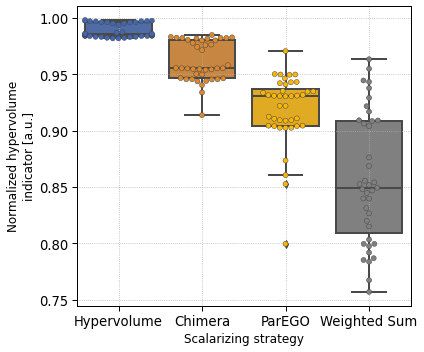

In [74]:
fig, ax = plt.subplots(figsize=(6, 5))

hue_order = ['#4267B2', '#dd882c', '#ffb703', 'gray']
order=['Hypervolume', 'Chimera', 'ParEGO', 'Weighted Sum']
pal = {o:h for o,h in zip(order, hue_order)}
sns.boxplot(data=df_hvol, x='kind', y='hypervol', palette=pal, ax=ax, linewidth=2.0)
sns.swarmplot(data=df_hvol, x='kind', y='hypervol', palette=pal, ax=ax, linewidth=0.5,)
ax.set_ylabel('Normalized hypervolume\nindicator [a.u.]', fontsize=12)
ax.set_xlabel('Scalarizing strategy', fontsize=12)
ax.grid(linestyle=":")

plt.tight_layout()
plt.savefig('redoxmers_hypervolume_boxplots.png', dpi=300)

In [48]:
fig = px.scatter_3d(df_hv, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_hv[df_hv['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# fig.update_layout(
#     title="Hypervolume",
#     xaxis_title=r'$\Delta_{abs}$ [nm]',
#     yaxis_title=r'$E^{red}$  [V vs. Li/Li+]',
#     zaxis_title=r'$G^{solv}$ [eV]',
#     #legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     )
# )

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

fig.write_image("hypervolume_redoxmers_run.png")
fig.show()

In [49]:
fig = px.scatter_3d(df_chi, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_chi[df_chi['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

#fig.write_image("chimera_redoxmers_run.png")
fig.show()

In [50]:
fig = px.scatter_3d(df_ws, x='abs_lam_diff', y='ered', z='gsol', size='size')

pareto_points = df_ws[df_ws['type']=='front']

fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

#fig.write_image("chimera_redoxmers_run.png")
fig.show()

In [51]:
fig = px.scatter_3d(df_par, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_par[df_par['type']=='front']

fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

#fig.write_image("chimera_redoxmers_run.png")
fig.show()